<a href="https://colab.research.google.com/github/divyanshuraj6815/eva/blob/master/Experiment%2014/experiment_14_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import time, math
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
tf.enable_eager_execution()


In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)
    self.drop = tf.keras.layers.Dropout(0.05)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.drop(self.conv(inputs))))

In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

In [0]:
class DavidNet(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

170500096/170498071 [==============================] - 11s 0us/step


In [0]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def create_tf_example (image, label):
  return tf.train.Example (features = tf.train.Features (feature = {'image' : _bytes_feature (image.tobytes ()), 'label' : _int64_feature (label)}))

In [0]:
def write_tf_records (x, y, file_path):
  writer = tf.python_io.TFRecordWriter (file_path)
  for i, x in enumerate (x_train):
    tf_example = create_tf_example (x, y[i])
    writer.write (tf_example.SerializeToString ())

In [0]:
write_tf_records (x_train, y_train, 'cifar10.tfrecords')

In [0]:
def decode (serialized_example):
  """
  Parses an image and label from the given `serialized_example`.
  It is used as a map function for `dataset.map`
  """
  IMAGE_SIZE = 40
  IMAGE_PIXELS = IMAGE_SIZE * IMAGE_SIZE * 3
  
  # 1. define a parser
  features = tf.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
          'image': tf.FixedLenFeature([], tf.string),
          'label': tf.FixedLenFeature([], tf.int64),
      })

  # 2. Convert the data
  image = tf.decode_raw(features['image'], tf.float32)
  image.set_shape((IMAGE_PIXELS))
  image = tf.cast (tf.reshape (image, [IMAGE_SIZE, IMAGE_SIZE, 3]), tf.float32)
  label = tf.cast(features['label'], tf.int64)

  # 3. reshape
  return image, label

In [0]:
def cutout (image, cutout_num):
  rand_x = np.random.randint (0, 32 + cutout_num)
  rand_y = np.random.randint (0, 32 + cutout_num)
  new_image = np.ones ([32 + cutout_num, 32 + cutout_num, 3])
  new_image[rand_x : rand_x + cutout_num, rand_y : rand_y + cutout_num, :] = 0
  new_image = new_image[cutout_num : cutout_num + 32, cutout_num : cutout_num + 32, :]

  mean_value = tf.reduce_mean(image, axis=(0, 1))
  mean_image = 1 - new_image
  mean_image = mean_image * mean_value

  mean_image = tf.convert_to_tensor (mean_image, dtype='float32')
  new_image = tf.convert_to_tensor (new_image, dtype='float32')
  image = image * new_image
  image = image + mean_image
  
  return image

In [0]:
model = DavidNet()
batches_per_epoch = len_train//BATCH_SIZE + 1

lr_schedule = lambda t: np.interp([t], [0, (EPOCHS+1)//5, EPOCHS], [0, LEARNING_RATE, 0])[0]
global_step = tf.train.get_or_create_global_step()
lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
opt = tf.train.MomentumOptimizer(lr_func, momentum=MOMENTUM, use_nesterov=True)
data_aug = lambda x, y: (cutout (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), 8), y)

In [15]:
dataset = tf.data.TFRecordDataset ('cifar10.tfrecords')
dataset = dataset.map (decode)

In [16]:
t = time.time()
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)
train_graph = {'epochs' : [], 'train_acc' : [], 'train_loss' : [], 'val_acc' : [], 'val_loss' : [], 'learning_rate' : [], 'time_taken' : []}

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  #train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(2)
  train_set = dataset.map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)
  
  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()
  
  train_graph['epochs'].append (epoch + 1)
  train_graph['train_loss'].append (train_loss / len_train)  
  train_graph['train_acc'].append (train_acc / len_train)  
  train_graph['val_loss'].append (test_loss / len_test)  
  train_graph['val_acc'].append (test_acc / len_test)  
  train_graph['learning_rate'].append (lr_schedule(epoch+1)) 
  train_graph['time_taken'].append (str (time.time() - t))

  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)


epoch: 1 lr: 0.08 train loss: 1.6319382934570312 train acc: 0.4101 val loss: 1.2189902954101564 val acc: 0.5692 time: 49.706650257110596



epoch: 2 lr: 0.16 train loss: 0.9693041491699219 train acc: 0.6516 val loss: 1.0326059600830078 val acc: 0.6525 time: 84.7468957901001



epoch: 3 lr: 0.24 train loss: 0.776511257019043 train acc: 0.72632 val loss: 0.8238079345703125 val acc: 0.7267 time: 119.65362191200256



epoch: 4 lr: 0.32 train loss: 0.6096484869384765 train acc: 0.78654 val loss: 0.612945083618164 val acc: 0.7935 time: 154.45560145378113



epoch: 5 lr: 0.4 train loss: 0.5910327728271484 train acc: 0.7964 val loss: 0.8002257080078125 val acc: 0.7505 time: 189.84716129302979



epoch: 6 lr: 0.37894736842105264 train loss: 0.50347150390625 train acc: 0.82494 val loss: 0.7042555923461914 val acc: 0.7821 time: 224.6243405342102



epoch: 7 lr: 0.35789473684210527 train loss: 0.47942848388671877 train acc: 0.8347 val loss: 0.49865257263183593 val acc: 0.8325 time: 259.4581458568573



epoch: 8 lr: 0.33684210526315794 train loss: 0.3299339596557617 train acc: 0.88464 val loss: 0.41446197891235353 val acc: 0.8628 time: 294.3006327152252



epoch: 9 lr: 0.31578947368421056 train loss: 0.27955874923706053 train acc: 0.90316 val loss: 0.4066913269042969 val acc: 0.8655 time: 328.97646951675415



epoch: 10 lr: 0.2947368421052632 train loss: 0.2766945907592773 train acc: 0.9038 val loss: 0.47861309967041016 val acc: 0.8408 time: 363.57980585098267



epoch: 11 lr: 0.2736842105263158 train loss: 0.29946488815307615 train acc: 0.8948 val loss: 0.40882860107421876 val acc: 0.8665 time: 398.2051131725311



epoch: 12 lr: 0.25263157894736843 train loss: 0.2304943600463867 train acc: 0.92004 val loss: 0.3432224182128906 val acc: 0.8871 time: 432.84639286994934



epoch: 13 lr: 0.23157894736842108 train loss: 0.2860311015319824 train acc: 0.89864 val loss: 0.3773386650085449 val acc: 0.8803 time: 467.602995634079



epoch: 14 lr: 0.2105263157894737 train loss: 0.1732596282196045 train acc: 0.9406 val loss: 0.3328969093322754 val acc: 0.8886 time: 502.43907737731934



epoch: 15 lr: 0.18947368421052635 train loss: 0.15594648002624512 train acc: 0.94592 val loss: 0.30237301483154294 val acc: 0.9036 time: 536.9686529636383



epoch: 16 lr: 0.16842105263157897 train loss: 0.13153443534851075 train acc: 0.9553 val loss: 0.30719107208251956 val acc: 0.8989 time: 571.4252874851227



epoch: 17 lr: 0.1473684210526316 train loss: 0.11275552139282227 train acc: 0.96136 val loss: 0.2895756565093994 val acc: 0.9083 time: 605.8030297756195



epoch: 18 lr: 0.12631578947368421 train loss: 0.09925643112182617 train acc: 0.96686 val loss: 0.26375854263305665 val acc: 0.9186 time: 640.3946118354797



epoch: 19 lr: 0.10526315789473689 train loss: 0.08645468082427979 train acc: 0.97126 val loss: 0.26149122619628906 val acc: 0.9198 time: 674.8949720859528



epoch: 20 lr: 0.08421052631578951 train loss: 0.07739617610931397 train acc: 0.97452 val loss: 0.277751469039917 val acc: 0.9171 time: 709.4415624141693



epoch: 21 lr: 0.06315789473684214 train loss: 0.07858073879241943 train acc: 0.97402 val loss: 0.2527305030822754 val acc: 0.9246 time: 743.7880206108093



epoch: 22 lr: 0.04210526315789476 train loss: 0.05946030746459961 train acc: 0.98074 val loss: 0.25302562599182127 val acc: 0.9242 time: 778.4134159088135



epoch: 23 lr: 0.02105263157894738 train loss: 0.08923401977539062 train acc: 0.96938 val loss: 0.2502327621459961 val acc: 0.9261 time: 813.1329884529114



epoch: 24 lr: 0.0 train loss: 0.12330818031311035 train acc: 0.95594 val loss: 0.24803774642944337 val acc: 0.9275 time: 847.4801714420319


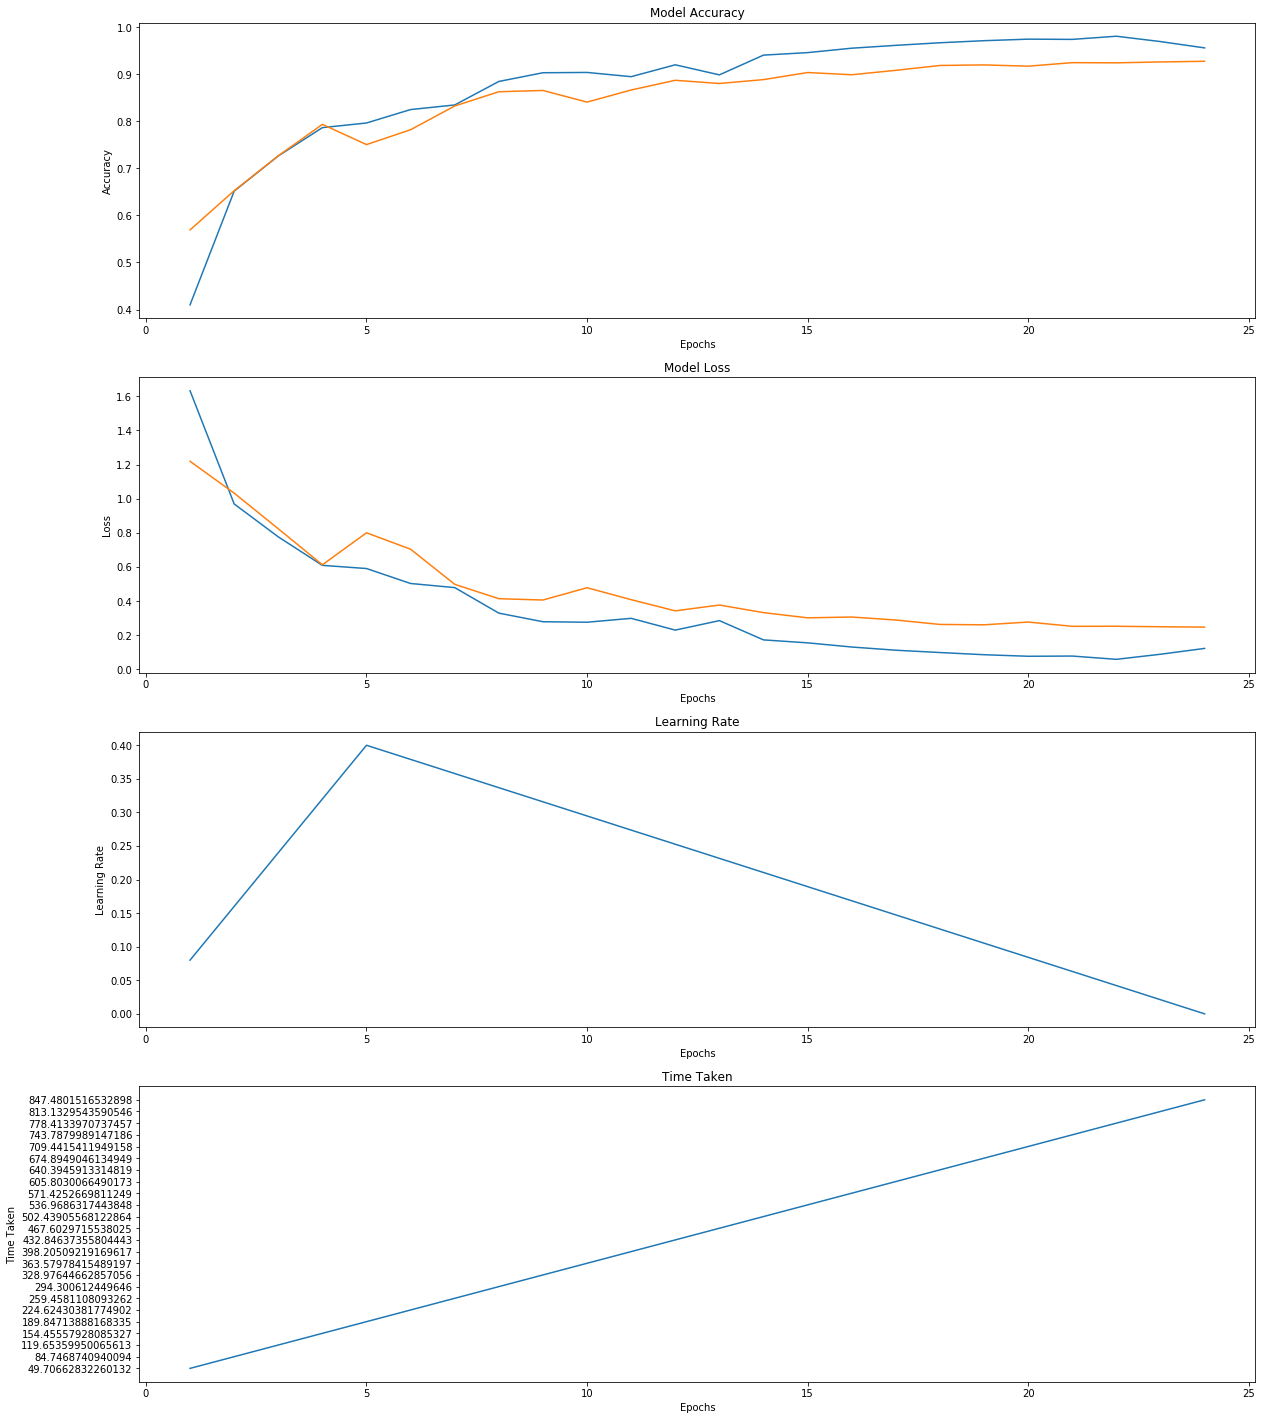

In [17]:
plt.figure (figsize=(20,25))
plt.subplot (411)
plt.title ('Model Accuracy')
plt.xlabel ('Epochs')
plt.ylabel ('Accuracy')
plt.plot (train_graph['epochs'], train_graph['train_acc'], train_graph['epochs'], train_graph['val_acc'])

plt.subplot (412)
plt.title ('Model Loss')
plt.xlabel ('Epochs')
plt.ylabel ('Loss')
plt.plot (train_graph['epochs'], train_graph['train_loss'], train_graph['epochs'], train_graph['val_loss'])

plt.subplot (413)
plt.title ('Learning Rate')
plt.xlabel ('Epochs')
plt.ylabel ('Learning Rate')
plt.plot (train_graph['epochs'], train_graph['learning_rate'])

plt.subplot (414)
plt.title ('Time Taken')
plt.xlabel ('Epochs')
plt.ylabel ('Time Taken')
plt.plot (train_graph['epochs'], train_graph['time_taken'])

plt.show ()